<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

Jupyter notebook housekeeping

In [57]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [58]:
# fix python path if working locally
#from utils import fix_pythonpath_if_working_locally
#
#fix_pythonpath_if_working_locally()
#%matplotlib inline



In [59]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Check whether GPU is available

In [60]:
import torch
torch.cuda.is_available()

False

Load data from prepared local csv file

In [61]:
from darts import TimeSeries
import pandas as pd


In [62]:
data_file_name = 'data/market_data.csv'

In [63]:

# load into a dataframe with valid market calendar days
raw_df = pd.read_csv(data_file_name, parse_dates=['Date'], index_col=['Date'])
raw_df


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00+00:00,0.054893,0.062965,0.054893,0.060274,1031788800,0.0,0.0
1986-03-14 00:00:00+00:00,0.060274,0.063504,0.060274,0.062427,308160000,0.0,0.0
1986-03-17 00:00:00+00:00,0.062427,0.064042,0.062427,0.063504,133171200,0.0,0.0
1986-03-18 00:00:00+00:00,0.063503,0.064042,0.061350,0.061888,67766400,0.0,0.0
1986-03-19 00:00:00+00:00,0.061888,0.062427,0.060274,0.060812,47894400,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-29 00:00:00+00:00,376.000000,377.160004,373.480011,376.040009,18723000,0.0,0.0
2024-01-02 00:00:00+00:00,373.859985,375.899994,366.769989,370.869995,25258600,0.0,0.0
2024-01-03 00:00:00+00:00,369.010010,373.260010,368.510010,370.600006,23083500,0.0,0.0


In [64]:
raw_df.index

DatetimeIndex(['1986-03-13 00:00:00+00:00', '1986-03-14 00:00:00+00:00',
               '1986-03-17 00:00:00+00:00', '1986-03-18 00:00:00+00:00',
               '1986-03-19 00:00:00+00:00', '1986-03-20 00:00:00+00:00',
               '1986-03-21 00:00:00+00:00', '1986-03-24 00:00:00+00:00',
               '1986-03-25 00:00:00+00:00', '1986-03-26 00:00:00+00:00',
               ...
               '2023-12-21 00:00:00+00:00', '2023-12-22 00:00:00+00:00',
               '2023-12-26 00:00:00+00:00', '2023-12-27 00:00:00+00:00',
               '2023-12-28 00:00:00+00:00', '2023-12-29 00:00:00+00:00',
               '2024-01-02 00:00:00+00:00', '2024-01-03 00:00:00+00:00',
               '2024-01-04 00:00:00+00:00', '2024-01-05 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=9531, freq=None)

In [65]:
type(raw_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [66]:
# raw_df.index = pd.to_datetime(raw_df.index, utc=True) 
# type(raw_df.index)

In [67]:
# raw_df.index

In [68]:
# check for missing values
raw_df.shape[0] - raw_df.dropna().shape[0]

0

In [69]:
raw_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00+00:00,0.054893,0.062965,0.054893,0.060274,1031788800,0.0,0.0
1986-03-14 00:00:00+00:00,0.060274,0.063504,0.060274,0.062427,308160000,0.0,0.0
1986-03-17 00:00:00+00:00,0.062427,0.064042,0.062427,0.063504,133171200,0.0,0.0
1986-03-18 00:00:00+00:00,0.063503,0.064042,0.061350,0.061888,67766400,0.0,0.0
1986-03-19 00:00:00+00:00,0.061888,0.062427,0.060274,0.060812,47894400,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-29 00:00:00+00:00,376.000000,377.160004,373.480011,376.040009,18723000,0.0,0.0
2024-01-02 00:00:00+00:00,373.859985,375.899994,366.769989,370.869995,25258600,0.0,0.0
2024-01-03 00:00:00+00:00,369.010010,373.260010,368.510010,370.600006,23083500,0.0,0.0


In [73]:

# series = TimeSeries.from_csv('data/market_data.csv', time_col='Date')
series = TimeSeries.from_dataframe(raw_df[['Close']], freq='B')
target = series

open = TimeSeries.from_dataframe(raw_df[['Open']], freq='B')
low = TimeSeries.from_dataframe(raw_df[['Low']], freq='B')
high = TimeSeries.from_dataframe(raw_df[['High']], freq='B')
volume = TimeSeries.from_dataframe(raw_df[['Volume']], freq='B')
dividends = TimeSeries.from_dataframe(raw_df[['Dividends']], freq='B')
stock_splits = TimeSeries.from_dataframe(raw_df[['Stock Splits']], freq='B')

past_covariates = open.stack(low).stack(high).stack(volume).stack(dividends).stack(stock_splits)


The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the 

Prepare train and validation splits

In [74]:
val_start = pd.Timestamp('2023-05-05')
train, val = target.split_before(val_start)


In [75]:
len(train), len(val)

(9691, 176)

In [76]:
train.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[0.06027414]],

       [[0.06242663]],

       [[0.06350351]],

       [[0.06188847]],

       [[0.06081223]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1986-03-13 1986-03-14 ... 1986-03-19
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [77]:
train_df = train.pd_dataframe()


In [78]:
# check for missing values
train_df.shape[0] - train_df.dropna().shape[0]

329

In [79]:
val.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[308.69094849]],

       [[306.70358276]],

       [[305.06399536]],

       [[310.34048462]],

       [[308.15432739]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-05-05 2023-05-08 ... 2023-05-11
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [80]:
val_df = val.pd_dataframe()
val_df

component,Close
Date,
2023-05-05,308.690948
2023-05-08,306.703583
2023-05-09,305.063995
2023-05-10,310.340485
2023-05-11,308.154327
...,...
2024-01-01,NaN
2024-01-02,370.869995
2024-01-03,370.600006


In [81]:
val_df.shape[0] - val_df.dropna().shape[0]

7

Plot data splits

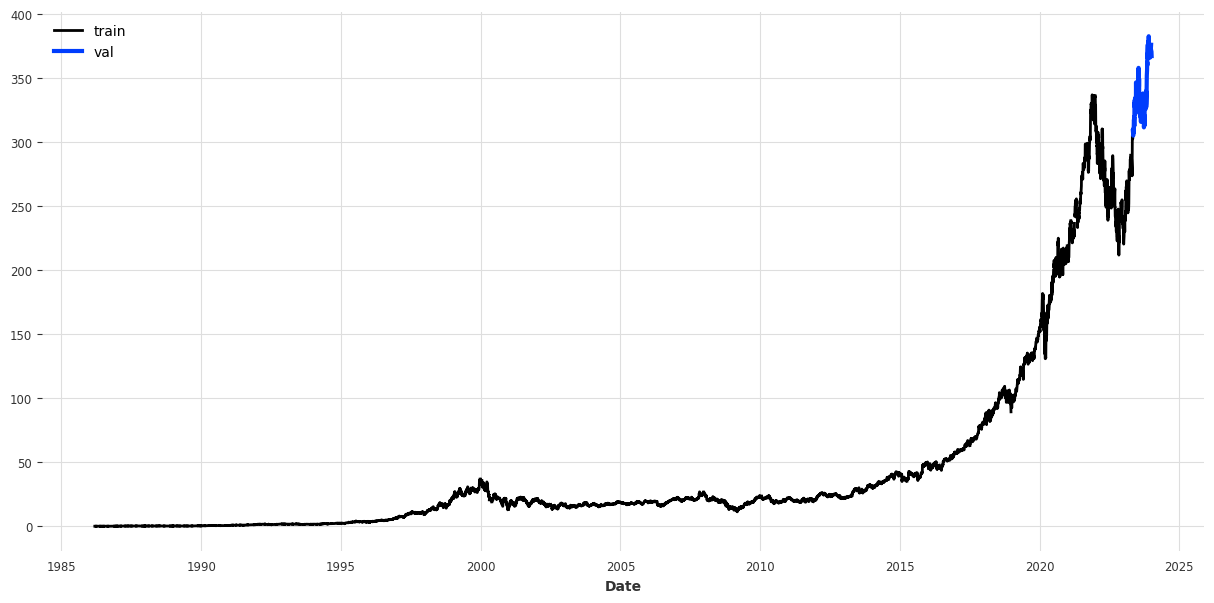

In [82]:
import matplotlib.pyplot as plt

train.plot(label='train')
val.plot(label='val', lw=3)
plt.legend()

Show seasonalities

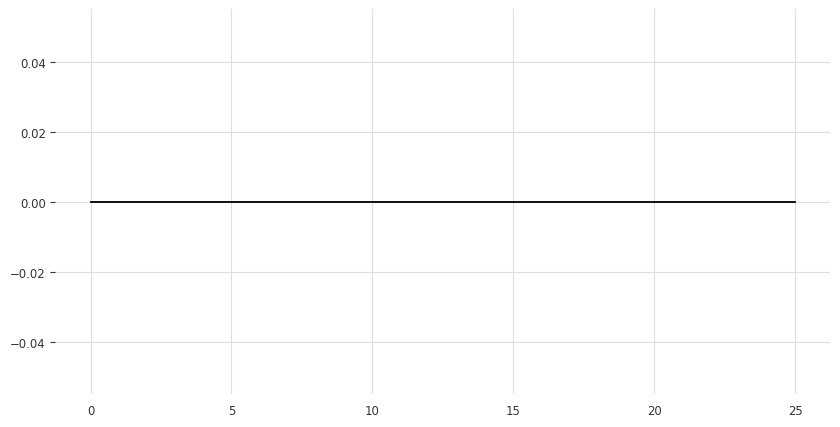

In [83]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, alpha=0.05)

Train our current working model

Prepare Encoders that Darts will automatically use for training and inference

In [84]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline
# 
scaler = Scaler(verbose=True, n_jobs=-1)
filler = MissingValuesFiller(verbose=True, n_jobs=-1)
pipeline = Pipeline([filler, scaler])

# darts encoder examples: https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#
encoders = {
    'cyclic': {'future': ['dayofweek', 'month', 'quarter']},
    "datetime_attribute": {"future": ["dayofweek", "month", "quater", "year"]}, 
    'position': {'past': ['relative'], 'future': ['relative']},
    "transformer": pipeline
}



In [85]:
train_history = 252*2 # 252 days in a year with market data
pred_horizon = 21*2 # 21 days in a month with market data
n_epochs = 2 # model training epochs

In [86]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'
model = None

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  model = TiDEModel.load(saved_model_name)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Creating a new model')
  model = TiDEModel(
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      # add_encoders=encoders,
      # dropout=0.1,
      n_epochs=n_epochs,
      use_reversible_instance_norm=True,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99])
#      model_name=saved_model_name,
#      force_reset=True,
#      save_checkpoints=True,    
  )  



Loading saved model
Error loading saved model: [Errno 2] No such file or directory: 'data/canswim_model.pt'
Creating a new model


In [87]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)

In [88]:
supports_multi_ts

True

In [89]:
# train model

model.fit(train, past_covariates=past_covariates, epochs=n_epochs, num_loader_workers=10)


GPU available: False, used: False


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params
---------------------------------------------------------
0 | criterion           | MSELoss          | 0     
1 | train_metrics       | MetricCollection | 0     
2 | val_metrics         | MetricCollection | 0     
3 | rin                 | RINorm           | 2     
4 | past_cov_projection | _ResidualBlock   | 1.4 K 
5 | encoders            | Sequential       | 661 K 
6 | decoders            | Sequential       | 1.2 M 
7 | temporal_decoder    | _ResidualBlock   | 4.6 K 
8 | lookback_skip       | Linear           | 148 K 
---------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.186     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 286/286 [00:11<00:00, 24.84it/s, train_loss=nan.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 286/286 [00:11<00:00, 24.84it/s, train_loss=nan.0]


TiDEModel(num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, input_chunk_length=504, output_chunk_length=42, n_epochs=2, use_reversible_instance_norm=True, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None))

In [90]:
# save model
model.save(saved_model_name)


In [91]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
pred = model.predict(pred_horizon, mc_dropout=True, num_samples=500) #   len(val))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


In [92]:
pred

<TimeSeries (DataArray) (Date: 42, component: 1, sample: 500)>
array([[[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-05-05 2023-05-08 ... 2023-07-03
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


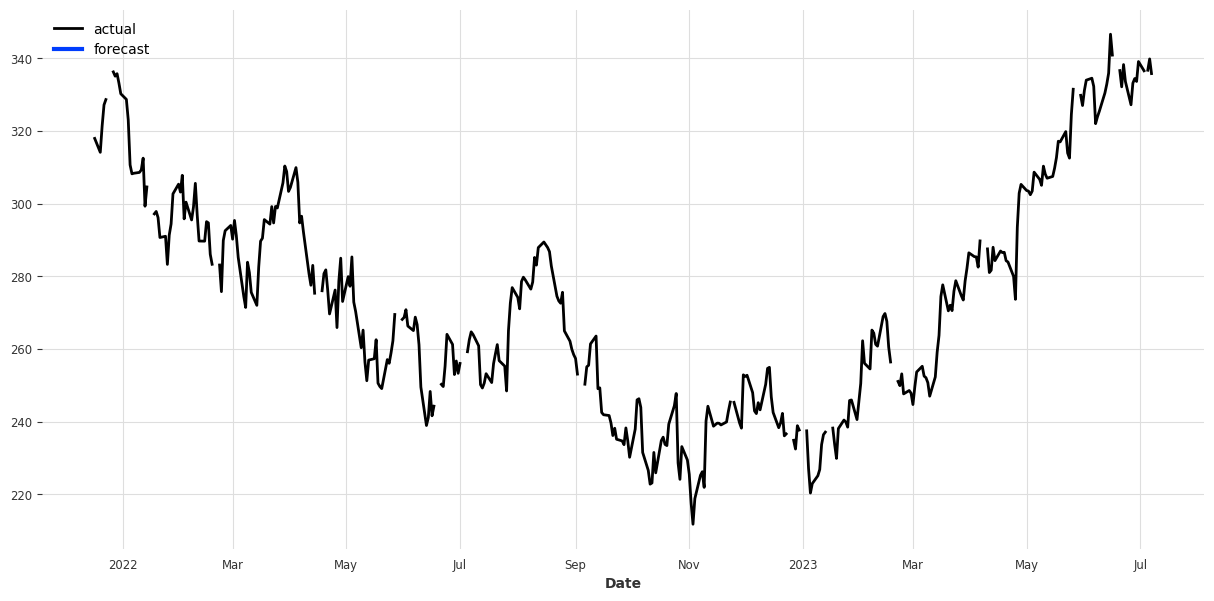

In [93]:
# select a reasonable range of train and val data points for convenient visualization of results
actual = target.slice(val_start-pd.Timedelta(days=train_history), val_start+pd.Timedelta(days=pred_horizon+21))
actual.plot(label='actual')
pred.plot(label='forecast', lw=3)
plt.legend()

Backtest Model


Backtest model on the full range of test data

In [96]:
from darts.metrics import rmse

def eval_model(model=None, series=None, start=None, past_covariates=None, future_covariates=None, forecast_horizon=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=start, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon,
                                          num_samples=500, # probabilistic forecasting
                                          predict_kwargs={'mc_dropout': True, 'num_loader_workers': 10, 'n_jobs': -1}
                                          )
    
    return backtest


In [97]:
# set the forecast start at a time before the validation date in order to see 
# the difference between predicting on training vs validation data
# predicting up to the validate date should be near match to actuals
# whereas predicting on unseen validate data should have room for improvement
forecast_start = val_start-pd.Timedelta(days=200)
forecast_horizon = pred_horizon # pred_horizon
backtest = eval_model(model=model, series=series, start=forecast_start, forecast_horizon=forecast_horizon)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 9/9 [00:32<00:00,  0.28it/s]


/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Backtest RMSE = nan


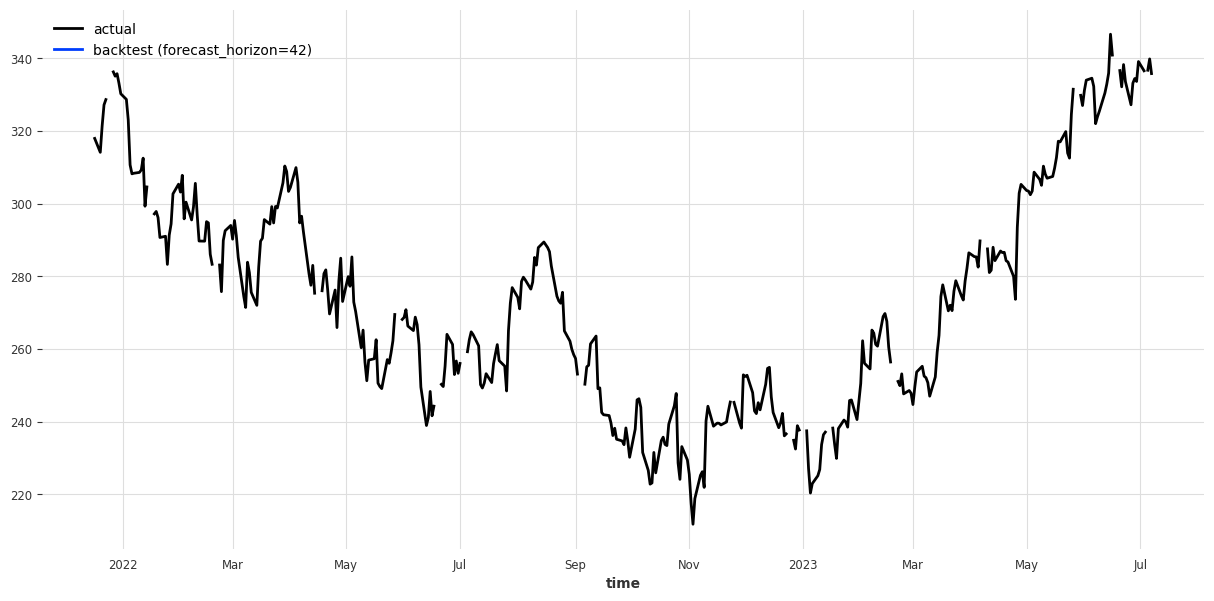

In [98]:

# plot results
actual.plot(label='actual')
backtest.plot(label=f'backtest (forecast_horizon={forecast_horizon})')
print('Backtest RMSE = {}'.format(rmse(target, backtest)))